# Аналитика в авиакомпании

##  Парсер для сбора с сайта данных о крупнейших фестивалях

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

URL = 'https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

table = soup.find('table',attrs={'id': 'best_festivals'})
heading_table = [] # Список, в котором будут храниться названия столбцов
for row in table.find_all('th'): # Названия столбцов прячутся в элементах th, 
# поэтому будем искать все элементы th внутри table и пробегать по ним в цикле
        heading_table.append(row.text) # Добавляем контент из тега th в список heading_table методом append()

content=[] # Список, в котором будут храниться данные из таблицы
for row in table.find_all('tr'): 
# Каждая строка обрамляется тегом tr, необходимо пробежаться в цикле по всем строкам
    if not row.find_all('th'): 
# Эта проверка необходима, чтобы пропустить первую строку таблицы с заголовками
            content.append([element.text for element in row.find_all('td')])
            # В каждой строке контент ячейки обрамляется тегами <td> </td>
            # Необходимо пробежаться в цикле по всем элементам td, вычленить контент из ячеек и добавить его в список 
            # Затем добавить каждый из списков в список content 

festivals  = pd.DataFrame(content, columns=heading_table)

## SQL запрос для выведения таблицы 

Для таблицы model_flights

SELECT

    aircrafts.model AS model,
    COUNT(flights.flight_id) AS flights_amount 
FROM

    flights
    LEFT JOIN aircrafts  ON aircrafts.aircraft_code = flights.aircraft_code
WHERE

    CAST(departure_time AS date) BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY

    model 
ORDER BY

    flights_amount

Для таблицы city_average_flights

SELECT

    T.city,
    AVG(T.flights_amount) AS average_flights
FROM (

    SELECT
        city,
        EXTRACT(day FROM flights.arrival_time) AS day_number,
        COUNT(flights.flight_id) AS flights_amount
    FROM
        flights
        INNER JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE
        CAST(flights.arrival_time AS date) BETWEEN '2018-08-01' AND '2018-08-31'
    GROUP BY
        city,
        day_number) AS T
GROUP BY

    city;

## Работа в python

In [2]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#откроем таблицу с моделями самолётов и количеством полётов на них в сентябре 2018 и выведем её на экран
model_flights = pd.read_csv('/datasets/query_1.csv')
model_flights

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [4]:
# посмотрим основные числовые характеристики для model_flights
model_flights.describe()

,flights_amount
count,8.000000
mean,2035.625000
std,1965.203947
min,300.000000
25%,605.250000
50%,795.000000
75%,4250.250000
max,4557.000000


In [5]:
# посмотрим основную информацию по таблицу model_flights
model_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [6]:
model_flights['flights_amount']=model_flights['flights_amount'].astype('int')

In [7]:
#откроем таблицу с городом и средним количеством входящих полётов в августе 2018 года и выведем её на экран
city_average_flights = pd.read_csv('/datasets/query_3.csv')
city_average_flights.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


In [8]:
# посмотрим основные числовые характеристики для city_average_flights
city_average_flights.describe()

,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194


In [9]:
# посмотрим основную информацию по таблицу city_average_flights
city_average_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


### Вывод

У нас есть две таблицы:
 1) Таблица с моделью самолёта и количество полётом на них в сентябре 2018 года
 
В ней 2 столбца:
 - model — модели самолета
 - flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года

И 7 строк, нет ни одного пропуска.

Столбец модели имеет тип данных object, стобец с количеством рейсой имел тип данных float64 (с плавающей запятой), я заменила его на int64 (целочисленный), ведь не может быть количество полётов 1/2.

 2) Таблица с городом и средним количеством входящих авиасообщений в день за август 2018 года

В ней 2 стоблца:
 - city — городах
 - average_flights — среднем количестве рейсов, прибывающих в город city за день в августе 2018 года

и 100 строк, где нет ни одного пропуска.

Столбец года  имеет тип данных object, стобец с количеством рейсой имеет тип данных float64.

## Исследовательский анализ данных

### Топ-10 городов по количеству рейсов

In [10]:
# Посмотрим нашу таблицу city_average_flights на первые 10 строчек по убыванию
# чтобы выяснить, 10 городов, с самым большим средним входящим потоком авиасообщений за август 2018 года

city_average_flights.sort_values(by = 'average_flights', ascending = False).head(10)

,city,average_flights
43,Москва,129.774194
70,Санкт-Петербург,31.161290
54,Новосибирск,17.322581
33,Красноярск,11.580645
20,Екатеринбург,11.322581
67,Ростов-на-Дону,10.193548
63,Пермь,10.129032
10,Брянск,10.000000
74,Сочи,9.612903
84,Ульяновск,9.580645


In [11]:
# Создадим переменную с перечислением наших 10 городов
top_10_city = [
    'Москва', 'Санкт-Петербург', 'Новосибирск', 'Красноярск', 'Екатеринбург',
    'Ростов-на-Дону', 'Пермь', 'Брянск', 'Сочи', 'Ульяновск']

# Создадим новую таблицу, в которой будет информация по играм из 5 платформ
top_10_city_average_flights = city_average_flights.query('city == @top_10_city')

### Построение графиков

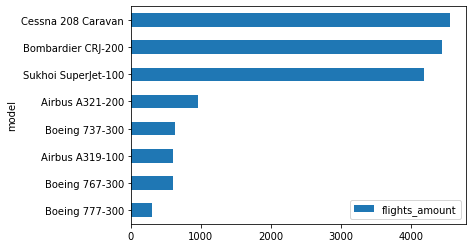

In [12]:
# Построим график для таблицы model_flights
model_flights.pivot_table(index='model', values='flights_amount')\
.sort_values('flights_amount', ascending = True)\
.plot(kind='barh');

По данному графику видим, что модели самолётов такие как Cessna 208 Caravan, Bombardier CRJ-200 и Sukhoi SuperJet-100 имеют самое большое количество полётов в месяц.	

Скорее всего это связано с тем, что у малогабаритных воздушных суден эксплуатация проще, чем у крупногабаритных.

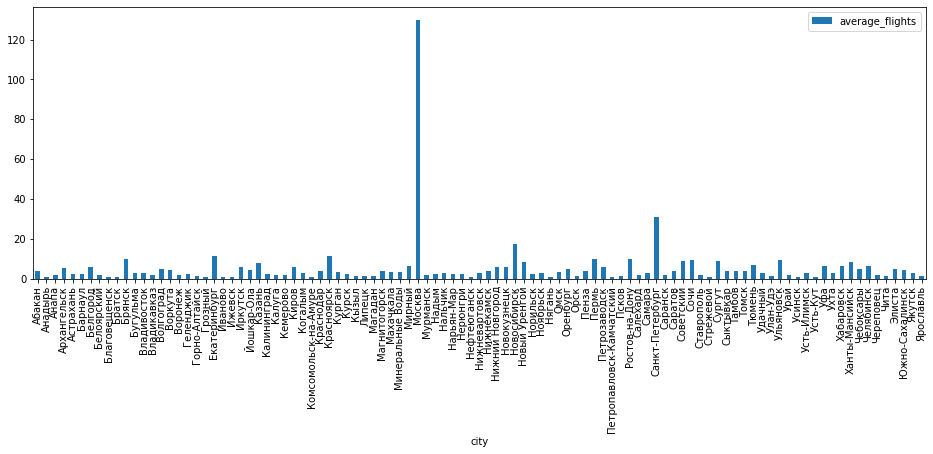

In [13]:
# Построим график для таблицы city_average_flights
city_average_flights.pivot_table(index='city', values='average_flights').plot(kind='bar', figsize=(16, 5));

По данному графику мы видим, что самое большое количество входящих авиасообщений имеет Москва, Санкт-Петербург и Новороссийск, но по топ 10 городам, мы рассмотрим следующий графк. По России, если не бракть крупные города, мало развито авиасообщение, в целом менее 5 самолётов в день прилётает в города.

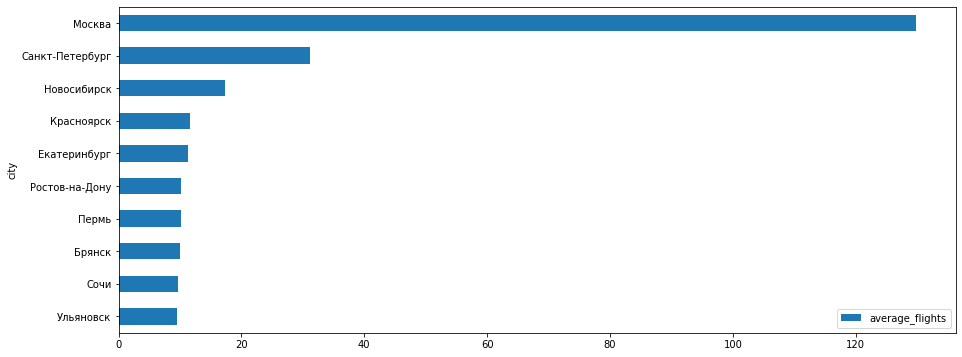

In [14]:
# Построим график для таблицы model_flights
top_10_city_average_flights\
.sort_values('average_flights', ascending = True)\
.plot(x='city', y='average_flights', figsize=(15,6), kind='barh');

В целом, если не брать в расчёт Москву, в то 10 городов прилетаемт около 10 авиасообщений в день. 

Лидируют города, которые являют крупными транспортными узлами и/или имеют важное экономическое значение.

## Общий вывод

На России самые распространённые модели самолётов это Bombardier CRJ-200, Cessna 208 Caravan и Sukhoi SuperJet-100.

Больше всего самолётов в день принимают такие города как Москва (более 120 самолётов в день) и Санкт-Петербург (чуть больше 30 самолётов в день).

По всем остальным городам можно судить, что авиасообщение в России развито плохо, в среднем это менее 5 входящих самолётов в день.